In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [5]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [10]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [11]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

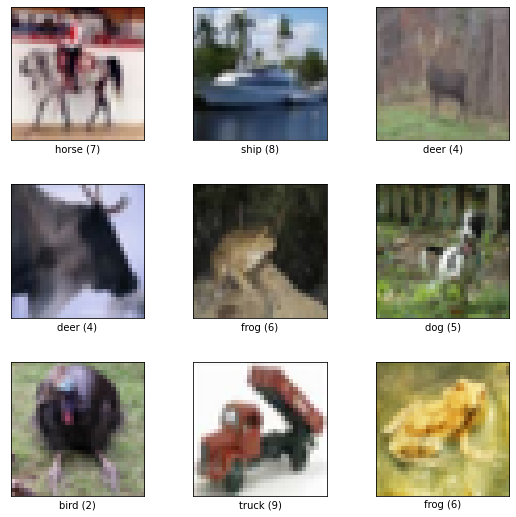

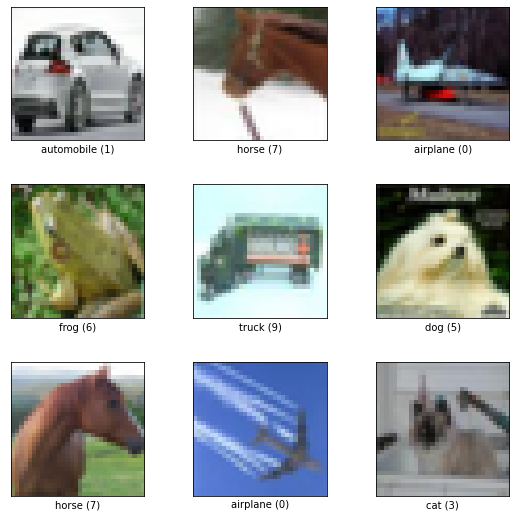

In [12]:
fig = tfds.show_examples(ds_train, ds_info)
fig = tfds.show_examples(ds_test, ds_info)

In [13]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [16]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [54]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
def conv_block_50(num,init_size,x,name):
    for i in range(0,num):
        if i == 0:
            short = x    
        x = Conv2D(filters= init_size,
                    kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_1')(x)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        x = Conv2D(filters= init_size,
                    kernel_size=(3,3),padding='same',name=f'stage{name}_{i+1}_2')(x)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)           
        x = Conv2D(filters= init_size*4,
                    kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_3')(x)
        x = BatchNormalization()(x)
        if i == 0:
            short = Conv2D(filters= init_size*4,
                        kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_short')(short)        
            short = BatchNormalization()(short)
        x = keras.layers.Add()([x,short])
        x = Activation(activation='relu')(x)
        short = x
    return x

def conv_block_34(num,init_size,x,name):
    for i in range(0,num):
        if i == 0:
            short = x    
        x = Conv2D(filters= init_size,
                    kernel_size=(3,3),padding='same',name=f'stage{name}_{i+1}_1')(x)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)           
        x = Conv2D(filters= init_size,
                    kernel_size=(3,3),padding='same',name=f'stage{name}_{i+1}_2')(x)
        x = BatchNormalization()(x)
        if i == 0:
            short = Conv2D(filters= init_size,
                        kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_short')(short)        
            short = BatchNormalization()(short)
        x = keras.layers.Add()([x,short])
        x = Activation(activation='relu')(x)
        short = x
    return x
def build_resnet(input_shape=(32,32,3), is_50 = True):
    Input_layer = keras.layers.Input(shape=input_shape)
    x = Conv2D(filters=64,kernel_size=(7,7),strides=2,padding= 'same')(Input_layer)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    x = MaxPool2D((3,3),strides=2,padding= 'same')(x)

    if is_50 == True:
        x = conv_block_50(3,64,x,2)
        x = Conv2D(128,(3,3),strides=2,padding='same')(x)
        x = conv_block_50(4,128,x,3)
        x = Conv2D(256,(3,3),strides=2,padding='same')(x)
        x = conv_block_50(6,256,x,4)
        x = Conv2D(512,(3,3),strides=2,padding='same')(x)
        x = conv_block_50(3,512,x,5)
        x = keras.layers.AveragePooling2D(pool_size=(1,1))(x)
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(10)(x)
    else:
        x = conv_block_34(3,64,x,2)
        x = Conv2D(128,(3,3),strides=2,padding='same')(x)
        x = conv_block_34(4,128,x,3)
        x = Conv2D(256,(3,3),strides=2,padding='same')(x)
        x = conv_block_34(6,256,x,4)
        x = Conv2D(512,(3,3),strides=2,padding='same')(x)
        x = conv_block_34(3,512,x,5)
        x = keras.layers.AveragePooling2D(pool_size=(1,1))(x)
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(10)(x)        
    model = keras.Model(inputs=Input_layer,outputs=x)
    return model
a = build_resnet(is_50 = False)
a.summary()

_________________
activation_1317 (Activation)    (None, 4, 4, 128)    0           add_401[0][0]                    
__________________________________________________________________________________________________
stage3_2_1 (Conv2D)             (None, 4, 4, 128)    147584      activation_1317[0][0]            
__________________________________________________________________________________________________
batch_normalization_1460 (Batch (None, 4, 4, 128)    512         stage3_2_1[0][0]                 
__________________________________________________________________________________________________
activation_1318 (Activation)    (None, 4, 4, 128)    0           batch_normalization_1460[0][0]   
__________________________________________________________________________________________________
stage3_2_2 (Conv2D)             (None, 4, 4, 128)    147584      activation_1318[0][0]            
___________________________________________________________________________________________

In [21]:
def conv_block_50(num,init_size,x):
    for i in range(0,num):
        short = x    
        x = Conv2D(filters= init_size,
                    kernel_size=(1,1),padding='same',name=f'stage2_{i}_1')(x)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        x = Conv2D(filters= init_size,
                    kernel_size=(3,3),padding='same',name=f'stage2_{i}_2')(x)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)           
        x = Conv2D(filters= init_size*4,
                    kernel_size=(1,1),padding='same',name=f'stage2_{i}_3')(x)
        x = BatchNormalization()(x)
        short = Conv2D(filters= init_size*4,
                    kernel_size=(1,1),padding='same',name=f'stage2_{i}_short')(short)
        short = Activation(activation='relu')(short)
        short = BatchNormalization()(short)
        x = keras.layers.Add()([x,short])
        # x = MaxPool2D((3,3),padding='same')(x)
        # x = Activation(activation='relu')(x)  
    return x